In [1]:
import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits
from astropy import wcs
fits_image_filename = '../Data/fits/calexp-1-136326.fits'

hdu_list = fits.open(fits_image_filename)
hdu = fits.open(fits_image_filename)[1]
w = wcs.WCS(hdu.header)

In [3]:
image_data = fits.getdata(fits_image_filename,0)
print(type(image_data))
print(image_data.shape)
# Parse the WCS keywords in the primary HDU
print(w)

<class 'numpy.ndarray'>
(6132, 8176)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 110.023098651493  50.3970383595424  
CRPIX : 4085.970136  3079.529769  
CD1_1 CD1_2  : -1.6539238537465e-07  -0.000346982198809907  
CD2_1 CD2_2  : 0.000346910845999464  -1.37876659879343e-07  
NAXIS : 8176  6132


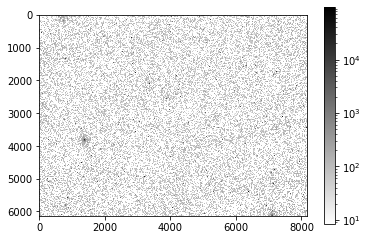

In [4]:
plt.imshow(image_data,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [5]:
from astropy.convolution import Gaussian2DKernel
from photutils import Background2D, MedianBackground
from photutils import detect_threshold, detect_sources
data = image_data
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)

In [6]:
from astropy.stats import gaussian_fwhm_to_sigma
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
#segm_deblend = deblend_sources(data, segm, npixels=npixels,filter_kernel=kernel, nlevels=32,contrast=0.001)

In [7]:
from photutils import source_properties
cat = source_properties(data, segm)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'
tbl['ycentroid'].info.format = '.2f'
tbl['ellipticity'].info.format = '.2f'
tbl['equivalent_radius'].info.format = '.2f'
print(tbl)

 id  xcentroid ycentroid ...         cyy                 gini       
        pix       pix    ...       1 / pix2                         
---- --------- --------- ... ------------------- -------------------
   1   8170.68      1.38 ...  0.8649557803497242  0.4743500139781945
   2   5534.93      4.19 ...   0.785970358071599  0.4460456701383804
   3   8116.53      6.85 ...  0.3427651428734173 0.26166118621361645
   4   7692.77      8.23 ...  0.4378250488372188  0.4258354151631234
   5   5260.31     10.31 ...    1.14226567518765  0.2774111270524478
   6   5958.99      9.71 ...   2.074712254429123 0.17203983458519773
   7   1061.80     13.62 ...   4.662833047032479 0.03051643192488274
   8   7903.09     18.15 ...  0.3156050450136545  0.5302576578998854
   9    813.76     20.39 ...  0.5377102042367432  0.6275235544889832
  10   8159.11     23.51 ...  0.2259482249800085  0.6093541850889812
 ...       ...       ... ...                 ...                 ...
5352   1841.89   6119.64 ...  0.65

## Cutouts

In [8]:
darray = np.asarray([source_properties(data,segm).xcentroid.value,source_properties(data,segm).ycentroid.value,source_properties(data,segm).elongation.value,source_properties(data,segm).equivalent_radius.value])
print(darray)
print(darray.shape)

[[8.17068307e+03 5.53492638e+03 8.11652581e+03 ... 1.05595408e+03
  4.20928817e+03 1.28000000e+03]
 [1.37995352e+00 4.18608479e+00 6.84893048e+00 ... 6.12538487e+03
  6.13053108e+03 6.13100000e+03]
 [1.70273092e+00 2.60326596e+00 2.46259389e+00 ... 1.86632905e+00
  1.60589584e+00 1.00000000e+00]
 [3.69963851e+00 4.06842895e+00 4.51351667e+00 ... 2.76395320e+00
  2.45924538e+00 1.38197660e+00]]
(4, 5361)


In [9]:
import pandas as pd
df = pd.DataFrame(data=darray.T,columns = ['xcentroid','ycentroid','elongation','equivalent radius'])
print(df)

        xcentroid    ycentroid  elongation  equivalent radius
0     8170.683066     1.379954    1.702731           3.699639
1     5534.926384     4.186085    2.603266           4.068429
2     8116.525808     6.848930    2.462594           4.513517
3     7692.768806     8.230611    2.745266           4.918491
4     5260.310856    10.306392    2.797919           3.141275
...           ...          ...         ...                ...
5356  2107.480239  6126.997243    1.375996           6.333012
5357  5830.385013  6124.449397    1.555058           2.646284
5358  1055.954078  6125.384873    1.866329           2.763953
5359  4209.288174  6130.531078    1.605896           2.459245
5360  1280.000000  6131.000000    1.000000           1.381977

[5361 rows x 4 columns]


In [10]:
indexNames = df[df['xcentroid'] < 400].index
print(indexNames)

Int64Index([  30,   52,   73,   89,   98,  123,  189,  208,  237,  238,
            ...
            5010, 5068, 5152, 5162, 5198, 5202, 5253, 5317, 5338, 5354],
           dtype='int64', length=233)


In [11]:
indexNames = df[df['xcentroid'] < 400].index
dfsel = df.drop(indexNames)
indexNames = dfsel[dfsel['xcentroid'] > 7776].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['ycentroid'] < 300].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['ycentroid'] > 5832].index
dfsel = dfsel.drop(indexNames)
indexNames = dfsel[dfsel['elongation'] > 10].index
dfsel = dfsel.drop(indexNames)
print(dfsel)

        xcentroid    ycentroid  elongation  equivalent radius
192   5713.963342   300.443271    2.769978           3.523363
193   6407.506745   303.293028    3.101391           3.141275
194   7522.804685   303.691475    3.701579           3.477898
195   7003.697445   306.617010    3.294647           3.656366
196   5244.092315   307.480301    2.324582           3.949327
...           ...          ...         ...                ...
5049  4280.704927  5824.722484    1.844931           2.326213
5050  7102.959676  5827.151764    1.344888           3.385138
5051  3322.472031  5830.262283    1.654276           4.333622
5052  7547.622591  5829.867772    1.343270           3.477898
5054  5382.928519  5829.325229    1.729344           2.763953

[4499 rows x 4 columns]


In [12]:
coords = list(zip(dfsel.xcentroid, dfsel.ycentroid))
print(coords)

[(5713.963342488908, 300.44327065286285), (6407.506744677393, 303.2930277913213), (7522.804684548545, 303.69147462536205), (7003.697444885158, 306.61700950096855), (5244.092314512107, 307.4803014351416), (740.7145110410095, 306.9865930599369), (1877.8979960578185, 309.1842148488831), (5667.646442360728, 308.56370656370655), (7749.691228070175, 307.5391812865497), (1563.6413074920451, 309.8706971362453), (4103.547138446925, 310.7827119449062), (7445.176704472433, 316.54478055519854), (6020.643463497453, 315.4248400156719), (6589.759512865875, 317.83941965413993), (3623.0814047276795, 318.49279268487464), (4567.581509344044, 317.8799571093032), (6154.222539353053, 318.05682407887906), (5527.529962546817, 317.61423220973785), (3533.7190929945295, 320.32758073054526), (713.7043381914259, 326.27776357282875), (7615.087435693672, 331.2267137897863), (2702.82890314696, 328.5481209899175), (2915.385091800203, 333.68301648383203), (1706.7375997496479, 331.8987638867157), (4940.524394004811, 333

In [13]:
from astropy import units as u
from astropy.nddata import Cutout2D
size = u.Quantity([40, 40], u.pixel)
cutout = []
cutout1 = Cutout2D(data=image_data,position=coords[1],size=40)
#for i in coords:
    #cutout.append(Cutout2D(data = image_data,position = coords[i],size = size))
#print(cutout)
print(cutout1)


In [14]:
print(hdu.data)

[[-2.66838074e+02 -9.17255878e+01 -5.00321388e+01 ...  7.77999759e+03
   1.56767368e+03  5.83708286e+02]
 [-6.67095184e+01 -7.50482082e+01 -2.00128555e+02 ...  1.10737801e+04
   2.70173550e+03  8.00514221e+02]
 [ 6.67095184e+01 -1.66773796e+02 -5.00321388e+01 ...  9.07249451e+03
   2.49326825e+03  7.75498152e+02]
 ...
 [ 1.00064278e+02  1.33419037e+02 -9.17255878e+01 ... -9.17255878e+01
  -6.67095184e+01 -8.33868980e+00]
 [-5.00222086e-12  5.00321388e+01  1.16741657e+02 ...  1.33419037e+02
   1.16741657e+02  2.50160694e+01]
 [ 7.50482082e+01  9.17255878e+01 -4.16934490e+01 ...  2.50160694e+01
  -8.33868980e+00 -1.08402967e+02]]


In [16]:
# Make the cutout, including the WCS
cutout = Cutout2D(image_data, position=coords[1000], size=size, wcs=w)

# Put the cutout image in the FITS HDU
hdu.data = cutout.data

# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header())

# Write the cutout to a new FITS file
cutout_filename = '001.fits'
hdu.writeto(cutout_filename, overwrite=True)

In [17]:
fits_image_filename = '001.fits'

hdu_list_cutout = fits.open(fits_image_filename)

image_data_cutout = fits.getdata(fits_image_filename,0)
print(type(image_data_cutout))
print(image_data_cutout.shape)

<class 'numpy.ndarray'>
(40, 40)


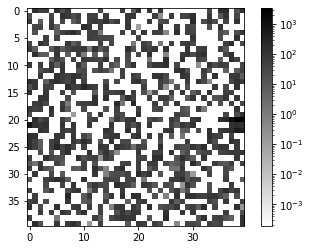

In [18]:
plt.imshow(image_data_cutout,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [19]:
hdu_list_cutout.info()

Filename: 001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU     94   (40, 40)   float64   


In [23]:
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(hdu_list_cutout[1].header)
print(w)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
WCS Keywords

Number

In [30]:
hdu_list_cutout_sky = w.all_pix2world(hdu_list_cutout[1],0)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

## Demo

In [ ]:
plt.imshow(image_data,cmap='gray_r',norm=LogNorm())
plt.colorbar()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x="elongation", y="equivalent radius")
fig.update_layout(xaxis_type="log", yaxis_type="log")
fig.show()

In [ ]:
print(df[df['equivalent radius'] > 20])

In [ ]:
print(df[(df['elongation'] > 3) & (df['equivalent radius'] > 4)])

In [ ]:
print(df[(df['xcentroid'] > 1480) & (df['xcentroid'] < 1490)])

In [ ]:
X = df[['elongation','equivalent radius']]
from sklearn import preprocessing                      #Feature scaling
scaler = preprocessing.RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=list(X.columns.values))
X = X_scaled
print(X_scaled.shape)  

## Clustering

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
Knumber=[]
CHnumber=[]
for i in range(2,9):
    Knumber.append(i)
    y_pred = KMeans(n_clusters=i).fit_predict(X)
    CHnumber.append(metrics.calinski_harabasz_score(X,y_pred))
plt.plot(Knumber,CHnumber,marker='o',ls='--')
plt.title('Looking for The Best K')
plt.xlabel('K')
plt.ylabel('Calinski-Harabasz Index')

In [ ]:
for i in [2,3]:
    kmeans = KMeans(n_clusters=i).fit(X)
    centroids = kmeans.cluster_centers_
    print('centers are:',centroids)

    fig= plt.figure(figsize=(20,10))
    x =X['equivalent radius']
    y =X['elongation']

    plt.scatter(x, y, c= kmeans.labels_.astype(float),s=5, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, alpha=1)
    plt.xlabel('equivalent radius')
    plt.ylabel('elongation')
    plt.title('K means clustering')

    plt.show()

## Sanity Check

In [ ]:
data = image_data[:500,:500]
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
threshold = bkg.background + (10. * bkg.background_rms)
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
segm = detect_sources(data, threshold, npixels=npixels,filter_kernel=kernel)
cat = source_properties(data, segm)
r = 3.  # approximate isophotal extent
apertures = []
for obj in cat:
    position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
    a = obj.semimajor_axis_sigma.value * r
    b = obj.semiminor_axis_sigma.value * r
    theta = obj.orientation.to(u.rad).value
    apertures.append(EllipticalAperture(position, a, b, theta=theta))

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(100, 125))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=LogNorm())
ax1.set_title('Data')
cmap = segm.make_cmap(random_state=12345)
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)